$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 3: Neural Network Regression

*Type your name here*

## Overview

Compare linear and neural network models applied to a data set of your choice.  

## Required Code

Download [nn1.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn1.tar) and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

as discussed in lecture. 

Write the following functions that train and evaluate linear and neural network models.

* `model = trainLinear(X,T,parameters)`
* `error = evaluateLinear(model,X,T)`
* `model = trainNN(X,T,parameters)`
* `error = evaluateNN(model,X,T)`

Write a new and improved version of the function we have been using to partition data into folds and combine them into training, validation and testing subsets.  Call this new version `trainValidateTestKFolds`.  Instead of returning data subsets, it applies train and evaluate functions to the subsets.  It uses the validation subset to determine the best model parameter values.  It must implement this algorithm:

```
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []

    # COMPLETE THIS FUNCTION BY IMPLEMENTING THE FOLLOWING STEPS.
    
    # For each test fold
        # For each set of parameter values, called parmSet
            # Find best set of parameter values
            # For each validate fold (except when same as test fold)
                # Use trainf to fit model to training data using parmSet
                # Calculate the error of this model by calling evaluatef with 
                  the model and validation data
            # Calculate the mean of these errors.
            # If this error is less than the previously best error for parmSet, 
              update best parameter values and best error
        # Make a new set of training data by concatenating the training and 
          validation data from previous step.
        # Retrain, using trainf again, to fit a new model to this new training data.
        # Calculate error of this new model on the test data, and also on the new 
          training data.
        # Construct a list of the best parameter values with this training error, 
          the mean of the above valdiation errors, and the testing error
        # Print this list if verbose == True
        # Append this list to a result list
    # Return this result list
``` 

In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mlutils as ml
import neuralnetworks as nn
import scaledconjugategradient as scg
import itertools

def trainLinear(X,T,parameters):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.hstack((np.ones((n,1)), (X - means)/stds))
    lambDiag = np.eye(d+1) * parameters
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1) + lambDiag, np.dot(Xs1.T,T))[0]
    return {'w': w, 'means':means, 'stds':stds}
    
def evaluateLinear(model,X,T):
    columnOfOnes = np.ones(( X.shape[0],1 ))
    Xs1 = np.hstack(( columnOfOnes, (X-model['means'])/model['stds']))
    A = np.dot( Xs1, model['w'] )
    return np.sqrt(np.mean( (A-T)**2 ))
    
def trainNN(X,T,parameters):
    net = nn.NeuralNetwork(X.shape[1],parameters[0],T.shape[1])
    train = net.train(X,T,nIterations = parameters[1])
    return train
    
def evaluateNN(model,X,T):
    use = model.use(X)
    error = np.sqrt(np.mean((use-T)**2))
    return error
    
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []

    # COMPLETE THIS FUNCTION BY IMPLEMENTING THE FOLLOWING STEPS.
    # For each test fold
    for testFold in range(nFolds):
        finalArray = []
        # For each set of parameter values, called parmSet
        for parmSet in parameterSets:
            newX = []
            newT = []
            # Find best set of parameter values
            bestError = []
            # For each validate fold (except when same as test fold)
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                
                # Use trainf to fit model to training data using parmSet
                model = trainf(Xtrain,Ttrain,parmSet)
                
                # Calculate the error of this model by calling evaluatef with the model 
                # and validation data
                error = evaluatef(model,Xvalidate,Tvalidate)
                bestError.append(error)
                
                # Make a new set of training data by concatenating the training and 
                # validation data from previous step.
                newX = np.vstack((Xtrain, Xvalidate))
                newT = np.vstack((Ttrain, Tvalidate))
                
                                
            # Calculate the mean of these errors.
            finalArray.append(np.array(bestError).mean())

        # If this error is less than the previously best error for parmSet,update best 
        # parameter values and best error
        idx = (np.argmin(np.array(finalArray)))
        
        # Retrain, using trainf again, to fit a new model to this new training data.
        reTrain = trainf(newX,newT,parameterSets[idx])
        # Calculate error of this new model on the test data, and also on the new training data.
        trainError = evaluatef(reTrain,newX,newT)
        testError = evaluatef(reTrain,Xtest,Ttest)
        
        # Construct a list of the best parameter values with this training error, the 
        # mean of the above valdiation errors, and the testing error
 
        iterResults = [parameterSets[idx], trainError, min(finalArray), testError]
        
        results.append(iterResults)
#         Print this list if verbose == True
    if verbose:
        print(result)

        # Append this list to a result list
        # Return this result list
    return np.array(results)
                
        

X = np.arange(20).reshape((-1,1))
T = np.abs(X -10) + X

result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,101,10),nFolds=5,shuffle=False)

print('Linear Model\nlambda, train, validate, test RMSE')
for x in result:
    print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))
      

parms = list(itertools.product([2,5,10, 20, [5,5], [10,2,10]], [10,20,100]))
result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms,nFolds=5,shuffle=False)

print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
for x in result:
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

# count = 0
# for x in result:
#     print (x,"\t",end=""),
#     count = count + 1
#     if count%4==0:
#         print()
# print('NN Model\n(hidden units, iterations), train, validate, test RMSE')

Linear Model
lambda, train, validate, test RMSE
10.00    3.158   4.132   2.414
20.00    4.368   5.021   3.641
10.00    3.245   4.178   5.030
20.00    4.448   6.070   2.024
20.00    2.426   2.972   10.886
NN Model
(hidden units, iterations), train, validate, test RMSE
(20, 10)  		    0.404   1.040   0.454
([5, 5], 100)  		    0.266   1.364   0.595
(20, 20)  		    0.145   0.503   1.226
(20, 100)  		    0.192   2.708   0.766
(20, 100)  		    0.120   0.725   1.317


The `parameters` argument to the `trainLinear` function is just the value of $\lambda$. For the `trainNN` function it must specify the hidden layer structure and the number of Scaled Conjugate Gradient iterations.  Here are some examples:
```
model = trainNN(X,T,[5, 100])       # Single hidden layer of 5 units, trained 
                                    # for 100 iterations
model = trainNN(X,T,[[10,10], 200]) # Two hidden layers, 10 units each, 
                                    # trained for 200 iterations
```

## Examples

```
X = np.arange(20).reshape((-1,1))
T = np.abs(X -10) + X

result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,101,10),nFolds=5,shuffle=False)
print('Linear Model\nlambda, train, validate, test RMSE')
for x in result:
    print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))
```
should result in
```
Linear Model
lambda, train, validate, test RMSE
10.00    3.158   4.132   2.414
20.00    4.368   5.021   3.641
10.00    3.245   4.178   5.030
20.00    4.448   6.070   2.024
20.00    2.426   2.972   10.886
```

An example of fitting a neural network to this data is
```
import itertools
parms = list(itertools.product([2,5,10, 20, [5,5], [10,2,10]], [10,20,100]))
result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms,nFolds=5,shuffle=False)
print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
for x in result:
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))
```
should result in something like 
```
NN Model
(hidden units, iterations), train, validate, test RMSE
([10, 2, 10], 100)  		    0.288   1.217   0.719
([5, 5], 100)  		    0.285   1.079   0.614
(20, 100)  		    0.073   0.532   0.920
(20, 100)  		    0.192   2.694   0.892
(20, 100)  		    0.129   0.788   2.451
```
Your results will differ, due to the initial random values for the neural network's weights.

## Data

Pick a data set from the [regression data sets](http://archive.ics.uci.edu/ml/datasets.html?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) at the UCI machine learning data repository.  Investigate the use of a linear model with various $\lambda$ values for your chosen data.  Then investigate the use of a neural network model on the same data for various sizes of hidden layers and numbers of iterations.

In [84]:
def makeYachtData(filename='yacht_hydrodynamics.data'):
    def missingIsNan(s):
        return np.nan if s == b'?' else float(s)
    data = np.loadtxt(filename, usecols=range(7))
    print("Read",data.shape[0],"rows and",data.shape[1],"columns from",filename)
    goodRowsMask = np.isnan(data).sum(axis=1) == 0
    data = data[goodRowsMask,:]
    print("After removing rows containing question marks, data has",data.shape[0],"rows and",data.shape[1],"columns.")
    X = data[:,:6]
    T = data[:,6:7]
    Xnames =  ['centerOfBuoyancy','prismastic','lengthDisplacement','beamDraught',
               'lengthBeamRatio','froudeNumber']
    Tname = 'resistancePerUnitWeightDisplacement'
    return X,T,Xnames,Tname

The below will give us an idea of what the visual relationship is between our yacht attributes (centerOfBuoyancy, prismastic coefficient, lengthDisplacement, beamDraught, lengthBeamRatio, froudeNumber) and the measured variable, the residuary resistance per unit weight of displacement.

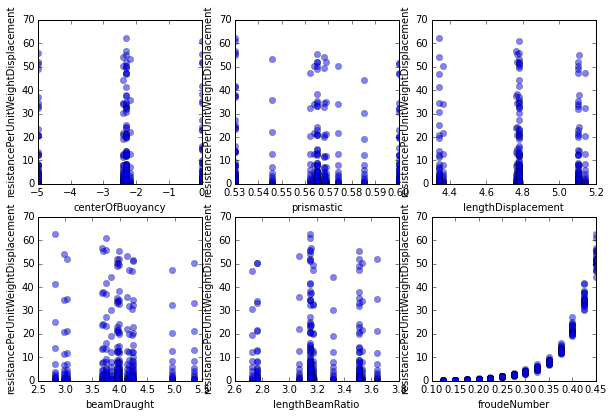

In [85]:
plt.figure(figsize=(10,10))
for c in range(X.shape[1]):
    plt.subplot(3,3, c+1)
    plt.plot(X[:,c], T, 'o', alpha=0.5)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])

Read 308 rows and 7 columns from yacht_hydrodynamics.data
After removing rows containing question marks, data has 308 rows and 7 columns.


Testing with nFolds of 10 at various values for parameterSets
Linear Model
lambda, train, validate, test RMSE

paramSets value: range(0,11,1)
4.00    8.873   8.922   8.734
7.00    8.939   8.995   8.146
5.00    8.872   8.916   8.821
9.00    8.992   9.059   7.575
7.00    8.824   8.878   9.232
7.00    8.897   8.950   8.548
7.00    8.710   8.747   10.299
8.00    8.754   8.805   9.856
7.00    8.824   8.867   9.284
8.00    8.909   8.970   8.566

paramSets value: range(0,101,10)
0.00    8.868   8.922   8.811
10.00    8.945   8.997   8.131
10.00    8.881   8.920   8.804
10.00    8.994   9.059   7.570
10.00    8.830   8.880   9.240
10.00    8.902   8.951   8.548
10.00    8.715   8.748   10.333
10.00    8.758   8.806   9.860
10.00    8.829   8.869   9.299
10.00    8.913   8.971   8.571

paramSets value: range(0,151,15)
0.00    8.868   8.922   8.811
15.00    

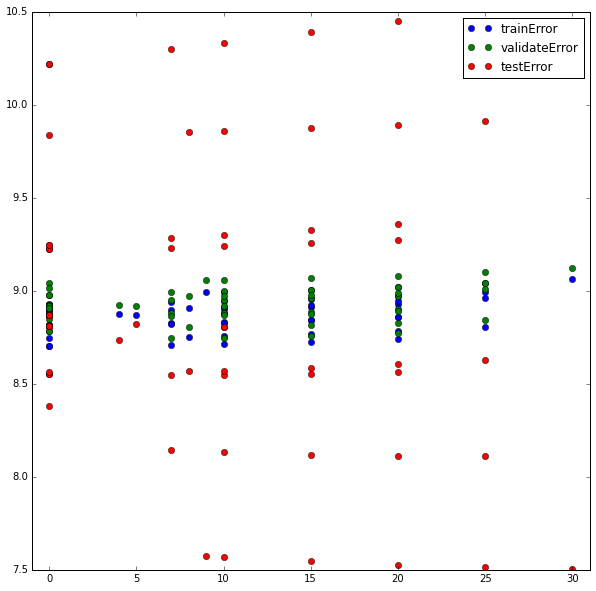

In [107]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mlutils as ml
import neuralnetworks as nn
import scaledconjugategradient as scg
import itertools




X,T,Xnames,Tname = makeYachtData()

parms = list(itertools.product([2,5,10, 20, [5,5], [10,2,10]], [10,20,100]))

result1 = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,11,1),nFolds=10,shuffle=False)
result2 = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,101,10),nFolds=10,shuffle=False)
result3 = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,151,15),nFolds=10,shuffle=False)
result4 = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,201,20),nFolds=10,shuffle=False)
result5 = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,251,25),nFolds=10,shuffle=False)
result6 = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,301,30),nFolds=10,shuffle=False)

paramSets = ['range(0,11,1)','range(0,101,10)','range(0,151,15)','range(0,201,20)','range(0,251,25)','range(0,301,30)']

plt.figure(figsize=(20,20))

finalArray = np.vstack((result1,result2,result3,result4,result5,result6))
count = 0
print ("\n\nTesting with nFolds of 10 at various values for parameterSets")
print('Linear Model\nlambda, train, validate, test RMSE')
for x in finalArray:
    if count%10==0:
        print("\nparamSets value: ",end="")
        print(paramSets[int(count/10)])
    print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))
    count = count+1

plt.figure(figsize=(10,10))
plt.plot(finalArray[:,:1],finalArray[:,1:2],'o',finalArray[:,:1],finalArray[:,2:3],'o',finalArray[:,:1],finalArray[:,3:4],'o')
plt.xlim(-1,max(finalArray[:,:1]+1))
plt.legend(('trainError','validateError','testError'),loc='best') 

In [144]:
X,T,Xnames,Tname = makeYachtData()

parms1 = list(itertools.product([1, 2, 4, 8, [1,1], [10,10]], [10,10,10]))
parms2 = list(itertools.product([1, 3, 9, 21, [2,2], [20,20]], [20,10,20]))
parms3 = list(itertools.product([[5,5], [10,2,10], [20,10,20]], [10,20,50]))

result1 = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms1,nFolds=5,shuffle=False)
result2 = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms2,nFolds=5,shuffle=False)
result3 = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms3,nFolds=5,shuffle=False)

finalArray = np.vstack((result1,result2,result3))

print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
for x in finalArray:
    print('{:}  \t\t\t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))


Read 308 rows and 7 columns from yacht_hydrodynamics.data
After removing rows containing question marks, data has 308 rows and 7 columns.
NN Model
(hidden units, iterations), train, validate, test RMSE
([10, 10], 10)  				    12.706   3.194   12.153
(4, 10)  				    4.020   4.792   4.098
(1, 10)  				    2.552   3.732   2.467
(4, 10)  				    3.593   5.323   4.332
(2, 10)  				    4.602   4.854   4.939
([2, 2], 20)  				    1.498   1.736   1.404
(1, 20)  				    1.588   1.697   1.722
(9, 20)  				    1.641   1.812   1.276
(3, 20)  				    4.569   1.598   5.184
(3, 20)  				    1.340   1.923   2.063
([20, 10, 20], 50)  				    0.566   1.310   1.492
([10, 2, 10], 50)  				    0.637   1.294   1.446
([20, 10, 20], 50)  				    0.509   2.231   0.687
([20, 10, 20], 50)  				    0.556   1.752   1.875
([5, 5], 20)  				    2.466   2.276   3.725


## Results

Discuss the results obtained, including the error values and the parameter values that result in the best performance.

__Linear Results:__

When comparing the results in the yacht data set against the linear results in the 

## Grading

Your notebook will be run and graded automatically. Download [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 80/100 if your functions are defined correctly.  The remaining 20% will be based on the instructors reading of your notebooks.  We will be looking for how well the method is explained in text with some LaTeX math, and how well the results are summarized.

In [5]:
%run -i "A3grader.py"

 Testing: result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                  range(0,101,10),nFolds=5,shuffle=False)
 Your result is
    10   3.158   4.132   2.414
    20   4.368   5.021   3.641
    10   3.245   4.178   5.03
    20   4.448   6.07   2.024
    20   2.426   2.972   10.89
20/20 points. First column, of best lambda values, is correct.
20/20 points. Columns of RMSE values are correct.

 Testing:
   import itertools
   parms = list(itertools.product([[5],[5,5],[2,2,2]], [10,50,100,200]))
   te = []
   for rep in range(5):
       result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                        parms,
                                        nFolds=4,shuffle=False)
       resulte = np.array([r[1:] for r in result])
       meanTestRMSE = resulte[:,-1].mean()
       print('     ',meanTestRMSE)
       te.append(meanTestRMSE)
      1.71153421008
      2.73341558571
      2.65865828346
      1.26378114136
      1.81521749337
40/40 point

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname A3.ipynb```.  So, for me it would be ```Anderson A3.ipynb```.  Submit the file using the ```Assignment 3``` link on [Canvas](https://colostate.instructure.com/courses/28803).

Grading will be based on 

  * correct behavior of the required functions,
  * readability of the notebook,
  * effort in making interesting observations, and in formatting your notebook.